# Riddler for April 5th 2019

## Table of Contents

1.  [Prompt](#prompt)  
2.  [Analytical solution (2 cards)](#2cardanalyze)  
2.1 [Probability of stopping with $l$ drinks left](#2cardProb)  
2.2 [Average number of drinks remaining](#2cardMean)  
2.3 [Probability that any drinks are left](#2cardDrinksLeft)  
3. [Simulation Solution (2 cards)](#2cardSim)
4. [Extra Credit](#extraCredit)  
4.1 [Distribution of Drinks Remaining vs Drinks Loaded (2 cards)](#drinksAsFunctionOfLoaded)  
4.2 [Mean drinks remaining and probability drinks are left vs # drinks loaded (2 cards)](#meanAsFunctionOfLoaded)  
4.3 [Analysis For Three Cards](#3cardAnalysis)  
4.4 [Simulation Solution for 3 Cards](#3cardSim)

## 1. Prompt <a id="prompt"></a>

In this notebook, we'll explore the [FiveThirtyEight Riddler from April 5th 2019](https://fivethirtyeight.com/features/does-your-gift-card-still-have-free-drinks-on-it/). I have copied the prompt below:

    Lucky you! You’ve won two gift cards, each loaded with 50 free 
    drinks from your favorite coffee shop, Riddler Caffei-Nation. 
    The cards look identical, and because you’re not one for 
    record-keeping, you randomly pick one of the cards to pay with 
    each time you get a drink. One day, the clerk tells you that 
    he can’t accept the card you presented to him because it doesn’t 
    have any drink credits left on it.

    What is the probability that the other card still has free 
    drinks on it? How many free drinks can you expect are still 
    available?

## 2. Analytical Solution <a id="2cardanalyze"></a>

### 2.1 Probability of stopping with $l$ drinks left <a id="2cardProb"></a>
First, we'll consider the probability that we stop our process with exactly $l$ drinks left on the non-empty card. We'll denote this by $P(\text{Stop with $l$ drinks left})$. To be ever-so-slightly more general, we'll allow both cards to have $n_{\text{drinks}}$ drinks on them.

For the sake of discussion, let's refer to our gift cards as A and B. Since both cards are identical, whenever we randomly pull a card out of our wallet to pay it's the same as flipping a fair coin to decide whether to use A or B. Without loss of generality, we will suppose that we choose A on heads and B on tails.

Then, consider the situation where we have reached the stopping criteria described in the prompt where we have pulled pulled out A and handed it to the barrista, and that there are $l$ drinks left on B. (The case where A and B are interchanged has an identical analysis).

Since we've just been alerted that A is empty, we have used it exactly $n_{\text{drinks}} + 1 $ times. Since $l$ drinks remain on B, we have used it $n_{\text{drinks}} - l$ times. In total, we've been to the shop  $n_{\text{trips}} = (n_{\text{drinks}} + 1) + (n_{\text{drinks}} - l) = 2 \cdot n_{\text{drinks}} - l + 1$ times. This is equivalent to having flipped a fair coin $2\cdot n_{\text{drinks}} - l + 1$ times where:
 1. we observe $n_{\text{drinks}} + 1$ heads
 2. we observe $n_{\text{drinks}} - l$ tails
 3. the last flip came up heads (since we used A last)

So:
$$ 
\begin{eqnarray}
  P(\text{Stop on $A$ with $l$ drinks left on $B$}) 
  &=& P(\text{$n_{\text{drinks}} + 1$ heads, $n_{\text{drinks}} - l$ tails, and last flip is heads}) \\
  &=& P(\text{$n_{\text{drinks}}$ heads, $n_{\text{drinks}} - l$ tails}) \cdot P(\text{heads}) \\
  &=& \text{Binomial PMF}(2\cdot n_{\text{drinks}} - l,~n_{\text{drinks}},~p = 0.5) \cdot 0.5
\end{eqnarray}
$$
 
By a symmetric argument, we find that $P(\text{Stop on $B$ with $l$ drinks left on $A$})$ has the same value. Since we either stop on card A or on card B it follows that:

$$ P(\text{Stop with $l$ drinks left}) = \text{Binomial PMF}(2\cdot n_{\text{drinks}} - l,~n_{\text{drinks}},~p=0.5)$$

Here, I'm using the notation for the Binomial point mass function from [here](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.binomial.html).

### 2.2 Average number of drinks remaining <a id="2cardMean"></a>
The average number of drinks remaining is given by the following expression:

$$ 
\begin{eqnarray}
E[n_{\text{drinks left}}] 
&=& \sum_{l = 0}^{n_{\text{drinks}}} l \cdot P(\text{Stop with $l$ drinks left}) \\
&=& \sum_{l = 0}^{n_{\text{drinks}}} l \cdot \text{Binomial PMF}(2\cdot n_{\text{drinks}} - l,~n_{\text{drinks}},~p=0.5) \\
\end{eqnarray}
$$

In the prompt, we have $n_{\text{drinks}} = 50$, so:
$$
\begin{eqnarray}
E[n_{\text{drinks left}}] 
&=& \sum_{l = 0}^{n_{\text{drinks}}} l \cdot \text{Binomial PMF}(100 - l,~50,~p=0.5) \\
&\approx& 7.0385\\ 
\end{eqnarray}
$$

### 2.3 Probability that any drinks are left <a id="2cardDrinksLeft"></a>
The probability that any drinks remain is:

$$ 
\begin{eqnarray}
P(\text{Stop with $l > 0$ drinks left}) &=& 1 - P(\text{Stop with $0$ drinks left}) \\
&=& 1 - \text{Binomial PMF}(2\cdot n_{\text{drinks}},~n_{\text{drinks}},~p=0.5)
\end{eqnarray}
$$

For the prompt, this is:

$$ 
\begin{eqnarray}
P(\text{Stop with $l > 0$ drinks left}) &=& 1 - \text{Binomial PMF}(100,~50,~p=0.5) \\
&\approx& 0.9204
\end{eqnarray}
$$


## 3. Simulation Solution: <a id="2cardSim"></a>

Now we'll simulate the process and plot the results of the simulation against the analytical results. We'll write our functions to be a bit more general than required by the prompt - however, I didn't get around to exploring anything more general than the situation described in the prompt.

I will provide a comparison of the simulated distribution of remaining drinks against the theoretical distribution described above. I also use the simulated distribution to estimate the average number of drinks remaining and the probability that our other card actually has some drinks left over.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib.ticker as mtick
import numpy as np
from scipy.stats import binom, multinomial

# simulate the draw-down process for the gift cards return the 
# number of drinks left on each card at the end
def simulate_giftcards(n_drinks_per_card = 50, n_cards = 2):
    drinks_left = np.array([n_drinks_per_card for i in range(n_cards)], dtype='int')

    while True:
        card_used = np.random.randint(0, n_cards)
        if drinks_left[card_used] == 0:
            break
        else:
            drinks_left[card_used] = drinks_left[card_used] - 1

    return drinks_left

# simulate the distribution of total drinks remaining on all giftcards
def simulate_drinks_left_distro(n_runs = 10000, n_drinks_per_card = 50, n_cards = 2):
    n_drinks_left = np.zeros(n_runs, dtype=int)

    for i in range(n_runs):
        n_drinks_left[i] = simulate_giftcards(n_drinks_per_card, n_cards).sum()

    return n_drinks_left

# Analytical distribution for 2 cards
def analytic_prob_2(n_drinks_per_card = 50):
    n_left = np.array(range(0, n_drinks_per_card+1))
    p_left = binom.pmf(n_drinks_per_card, 2 * n_drinks_per_card - n_left, 0.5)
    return p_left

# Plot the result under the prompt's parameters
def plot_riddler_results(n_runs = 10000):
    # This is fixed
    n_cards = 2
    n_drinks_per_card = 50
    
    # Simulate results / print info
    n_drinks_left_sim = simulate_drinks_left_distro(n_runs)
    avg_remaining_sim = np.mean(n_drinks_left_sim)
    prob_nonzero_sim  = np.count_nonzero(n_drinks_left_sim) / n_runs
    print("Simulation results ({0} cards, {1} drinks/card)".format(n_cards, n_drinks_per_card))
    print("----------------------------------------")
    print("Average drinks remaining : ", avg_remaining_sim)
    print("Probability drinks remain: ", prob_nonzero_sim)
    print("")

    # Solve analytically
    n_left = np.array(range(0, n_drinks_per_card+1))
    p_left = analytic_prob_2(n_drinks_per_card)
    avg_remaining_analytic = np.sum(n_left * p_left)
    prob_nonzero_analytic = 1.0 - p_left[0]
    print("Analytical results ({0} cards, {1} drinks/card)".format(n_cards, n_drinks_per_card))
    print("----------------------------------------")
    print("Average drinks remaining : ", avg_remaining_analytic)
    print("Probability drinks remain: ", prob_nonzero_analytic)
    print("") 

    # Plot the figure with comparison
    fig, ax = plt.subplots()
    ax.hist(n_drinks_left_sim, bins=range(0, n_drinks_per_card+1),
            density=True, label="Simulated")
    ax.plot(n_left, p_left, drawstyle="steps-post",
            label = "Analytical")
    ax.set_xlabel("Drinks Remaining")
    ax.set_ylabel("Frequency")
    
    ax.legend()
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=1))
    plt.show()

Simulation results (2 cards, 50 drinks/card)
----------------------------------------
Average drinks remaining :  7.0789
Probability drinks remain:  0.9188

Analytical results (2 cards, 50 drinks/card)
----------------------------------------
Average drinks remaining :  7.038512976105146
Probability drinks remain:  0.9204107626128211



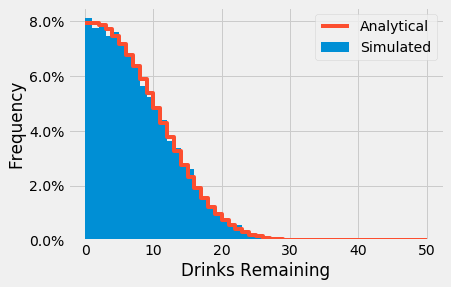

In [2]:
%matplotlib inline
np.random.seed(8675309)
style.use('fivethirtyeight')
plot_riddler_results(10000)

## 4. Extra Credit <a id="extraCredit"></a>

In this section, I'm going to expand on the analysis / code from above. We will do three things,
  1. First, we'll take a look at how the distribution of remaining drinks varies as we change the number of drinks loaded per card. Previously we just looked at this distribution for 50 drinks/card, but we'll check it out for a few other values.
  2. Next, we'll take a look at how the mean number of drinks remaining / probability that any drinks are left varies as a function of the number of drinks loaded per card.
  3. Finally. I'll extend the analysis to 3 cards and repeat the results we saw above. 

### 4.1 Distribution of Drinks Remaining vs Drinks Loaded <a id="drinksAsFunctionOfLoaded"></a>

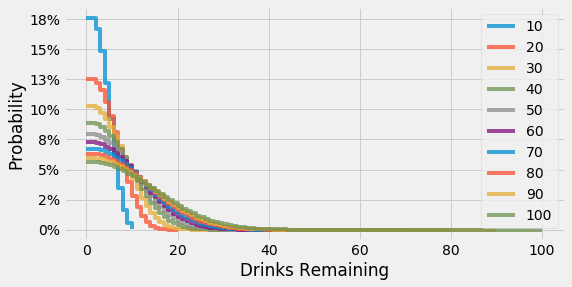

In [3]:
fig, ax = plt.subplots(figsize=(8,4))
for n_drinks_per_card in range(10, 100+1, 10):
    p_left = analytic_prob_2(n_drinks_per_card)
    ax.plot(p_left, drawstyle="steps-post", label=n_drinks_per_card, alpha = 0.75)
ax.legend()
ax.set_xlabel("Drinks Remaining")
ax.set_ylabel("Probability")
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))
plt.show()

### 4.2 Mean Drinks Remaining and Probability Drinks are Left  vs Drinks Loaded <a id="meanAsFunctionOfLoaded"></a>

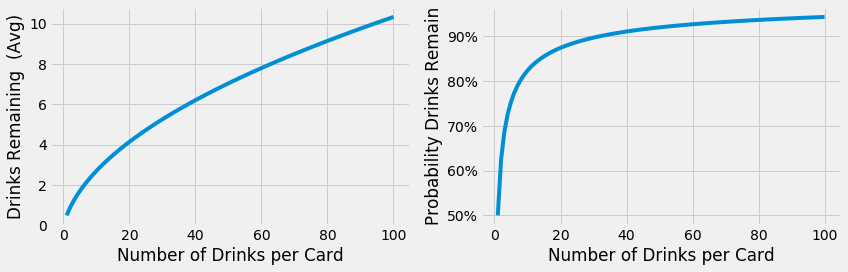

In [4]:
n_max = 100
n_drinks_per_card = np.arange(1,n_max+1)
mean_drinks_left = np.zeros(n_max)
prob_some_left   = np.zeros(n_max)

for i in n_drinks_per_card:
    n_left = np.arange(0, i+1)
    p_left = analytic_prob_2(i)
    mean_drinks_left[i - 1] = np.sum( n_left * p_left )
    prob_some_left[i - 1] = 1.0 - p_left[0]    

fig, axs = plt.subplots(1, 2, figsize = (12, 4))
ax = axs[0]
ax.plot(n_drinks_per_card, mean_drinks_left)
ax.set_ylabel("Drinks Remaining  (Avg)")
ax.set_xlabel("Number of Drinks per Card")

ax = axs[1]
ax.plot(n_drinks_per_card, prob_some_left)
ax.set_ylabel("Probability Drinks Remain")
ax.set_xlabel("Number of Drinks per Card")
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))

plt.tight_layout()
plt.show()

### 4.3 Analysis For Three Cards <a id="3cardAnalysis"></a>
    
Let's briefly extend the derivation from above to three cards. To start, we'll now label the cards A, B, and C. Then, a straightforward extension of the earlier derivation gives: 
$$ 
\begin{eqnarray}
  P(\text{Stop on $A$ with $l_B$ drinks left on $B$ and $l_C$ on $C$}) 
  = 1/3 \cdot \text{Multinomial PMF} (x &=& (n_{\text{drinks}},~n_{\text{drinks}} - l_B,~n_{\text{drinks}} - l_C),\\
  ~~N &=& 3\cdot n_{\text{drinks}} - l_B - l_C, \\
  ~~p &=& [1/3,1/3,1/3] )
\end{eqnarray}
$$
Here, I've been somewhat lazy concecptually (sorry if you're reading this!) and am also using the notation from [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multinomial.html).


Then, the probability that we stop with $l$ drinks remaining on any card is obtained as follows:
$$ 
\begin{eqnarray}
  &P&(\text{Stop with $l$ drinks left on other cards}) \\
  &&= \sum_{l_B = 0}^{l} \text{Multinomial PMF} (x = (n_{\text{drinks}},~n_{\text{drinks}} - l_B,~n_{\text{drinks}} - (l - l_B)), ~N = 3\cdot n_{\text{drinks}} - l, ~p = [1/3,1/3,1/3] )
\end{eqnarray}
$$

The mean number of drinks remaining and probability that any drinks are left can be calculated from this as above.

### 4.4 Simulation Solution for Three Cards <a id="3cardSim"></a>

Now that we know what the answer should be, let's simulate it and compare the analytical result to the simulation result.

In [5]:
def analytic_prob_3(n_drinks_per_card = 50):
    n_cards = 3    
    n_left = np.array(range(0, 2 * n_drinks_per_card + 1))
    p_left = np.zeros(2 * n_drinks_per_card+1)
    
    for l in range(len(p_left)):
        n   = np.empty(l+1)
        n.fill(3 * n_drinks_per_card - l)
        
        n_A = np.empty(l+1)
        n_A.fill(n_drinks_per_card)
        
        l_B = np.array(range(0, l +1))
        n_B = n_drinks_per_card - l_B
        n_C = n_drinks_per_card - (l - l_B)
        
        tmp = np.array([n, n_A, n_B, n_C]).T
        tmp = tmp[tmp.min(axis=1)>=0, :]
        n = tmp[:, 0]        
        tmp = tmp[:, 1:]
        
        p_left[l] = multinomial.pmf(
                tmp, 
                n = n,  
                p = np.array([1.0/3.0, 1.0/3.0, 1.0/3.0])
        ).sum()
        
    return p_left

def plot_sim_analytic_comp_3(n_runs = 10000, n_drinks_per_card = 50):
    # Simulate results for 3 cards / print info
    n_cards = 3
    n_drinks_left_sim = simulate_drinks_left_distro(n_runs, n_drinks_per_card, n_cards)
    avg_remaining_sim = np.mean(n_drinks_left_sim)
    prob_nonzero_sim  = np.count_nonzero(n_drinks_left_sim) / n_runs
    print("Simulation results ({0} cards, {1} drinks/card)".format(n_cards, n_drinks_per_card))
    print("----------------------------------------")
    print("Average drinks remaining : ", avg_remaining_sim)
    print("Probability drinks remain: ", prob_nonzero_sim)
    print("")

    # Analytical distro for 3 cards
    n_left = np.array(range(0, 2 * n_drinks_per_card+1))
    p_left = analytic_prob_3(n_drinks_per_card)
    avg_remaining_analytic = np.sum(n_left * p_left)
    prob_nonzero_analytic = 1.0 - p_left[0]
    print("Analytical results ({0} cards, {1} drinks/card)".format(n_cards, n_drinks_per_card))     
    print("----------------------------------------")
    print("Average drinks remaining : ", avg_remaining_analytic)
    print("Probability drinks remain: ", prob_nonzero_analytic)
    print("") 
    
    # Plot the figure with comparison
    fig, ax = plt.subplots()
    ax.hist(n_drinks_left_sim, bins=range(0, 2*n_drinks_per_card+1), density=True, label="Simulated")      
    ax.plot(range(0, 2*n_drinks_per_card+1), p_left, drawstyle="steps-post", label = "Analytical")
    ax.set_xlabel("Drinks Remaining")
    ax.legend()
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))
    
    return ax    

Simulation results (3 cards, 50 drinks/card)
----------------------------------------
Average drinks remaining :  15.8056
Probability drinks remain:  0.9952

Analytical results (3 cards, 50 drinks/card)
----------------------------------------
Average drinks remaining :  15.811392747341372
Probability drinks remain:  0.9945111598192252



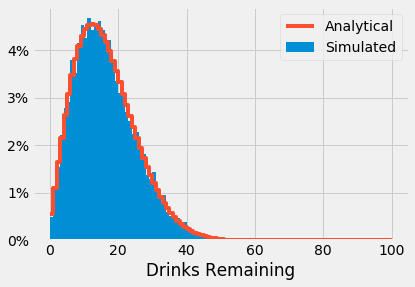

In [6]:
np.random.seed(1984)
plot_sim_analytic_comp_3(n_runs = 10000, n_drinks_per_card = 50)
plt.show()

Good, we see agreement between our prediction and our simulation - so we're not likely to be wrong (:

Also, we see that you're much more likely to still have drinks remaining when the Barrista stops you if you had 50 drinks loaded on 3 cards instead of 2 cards. Likewise, on average you'll have almost twice as many drinks left over.